# CONFIG

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import numpy as np

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid, StratifiedKFold

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
import pickle

In [ ]:
import random

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [ ]:
DEFAULT_PATH = 'default_path'
DATA_PATH = DEFAULT_PATH + 'data_path'

In [ ]:
data = pd.read_csv(DATA_PATH)

# PP

In [ ]:
'''  data load  '''

data.drop(columns = ['customerID', 'gender', 'PhoneService'],inplace = True)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [ ]:
'''  data labeling  '''

columns_to_label = [
    'Partner', 'Dependents', 'MultipleLines',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'PaperlessBilling', 'Churn'
]

# 'Yes' -> 1, 'No' and other similar values -> 0
data[columns_to_label] = data[columns_to_label].replace({
    'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0
})

# change 'Contract' column to months
data['Contract'] = data['Contract'].replace({
    'Month-to-month': 1,
    'One year': 12,
    'Two year': 24
})

# label 'PaymentMethod' column in order of inconvenience # Credit=0, Bank=1, Mailed=2, Electronic=3
data['PaymentMethod'] = data['PaymentMethod'].replace({
    'Electronic check': 3,
    'Mailed check': 2,
    'Bank transfer (automatic)': 1,
    'Credit card (automatic)': 0
})

# label 'InternetService' column in order of expense
data['InternetService'] = data['InternetService'].replace({
    'No': 0,
    'DSL': 1,
    'Fiber optic': 2
})

In [ ]:
''' add a service num column '''

services_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                 'StreamingTV', 'StreamingMovies', 'MultipleLines']

data['Services'] = data[services_cols].apply(lambda x: (x == 1).sum(), axis=1)

In [ ]:
''' missing value imputation '''

data['TotalCharges'] = data.apply(
    lambda row: row['MonthlyCharges'] * row['tenure'] if pd.isnull(row['TotalCharges']) else row['TotalCharges'],
    axis=1
)

In [ ]:
''' column cleanup '''

cols = [col for col in data.columns if col != 'Churn'] + ['Churn']
data = data[cols]

In [ ]:
''' method : preparing data set '''

def split_data(data_dict, test_size=0.2, random_state=42):
    train_test_data = {}
    for key, data in data_dict.items():
        train, test = train_test_split(data, test_size=test_size, random_state=random_state)
        train_test_data[f'{key}_train'] = train
        train_test_data[f'{key}_test'] = test
    return train_test_data

# def scale_data(train_data, test_data, columns_to_scale, key): # find
#     scaler = MinMaxScaler()
#     train_data_scaled = train_data.copy()
#     train_data_scaled[columns_to_scale] = scaler.fit_transform(train_data_scaled[columns_to_scale])
#     test_data_scaled = test_data.copy()
#     test_data_scaled[columns_to_scale] = scaler.transform(test_data_scaled[columns_to_scale])

#     with open(f'{key}_scaler.pkl', 'wb') as file:
#         pickle.dump(scaler, file)

#     return train_data_scaled, test_data_scaled

def scale_data_full_dataset(train_data, test_data, columns_to_scale, key): # final
    combined_data = pd.concat([train_data, test_data], axis=0)

    scaler = MinMaxScaler()
    combined_data_scaled = combined_data.copy()
    combined_data_scaled[columns_to_scale] = scaler.fit_transform(combined_data_scaled[columns_to_scale])

    train_data_scaled = combined_data_scaled.iloc[:len(train_data)].reset_index(drop=True)
    test_data_scaled = combined_data_scaled.iloc[len(train_data):].reset_index(drop=True)

    with open(f'{key}_scaler.pkl', 'wb') as file:
        pickle.dump(scaler, file)

    return train_data_scaled, test_data_scaled

def apply_smote(train_data, target_column, sampling_strategy=1, random_seed=42):
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]

    over = SMOTE(sampling_strategy=sampling_strategy, random_state=random_seed)
    X_resampled, y_resampled = over.fit_resample(X_train, y_train)

    return pd.DataFrame(X_resampled, columns=X_train.columns), pd.Series(y_resampled)

def process_data_with_smote(data_dict, target_column):
    resampled_results = {}

    for key in data_dict.keys():
        if 'train' in key:
            resampled_X, resampled_y = apply_smote(data_dict[key], target_column)
            resampled_data = resampled_X.copy()
            resampled_data[target_column] = resampled_y
            resampled_results[key] = resampled_data
        if 'test' in key:
            resampled_results[key] = data_dict[key]
    return resampled_results

In [ ]:
''' src : preparing data set '''

columns_to_split = ['Partner', 'Dependents']
data_dict = {'data': data}

for partner_val in [0, 1]:
    for dependents_val in [0, 1]:
        filtered_data = data[(data['Partner'] == partner_val) & (data['Dependents'] == dependents_val)].drop(columns=columns_to_split)
        key_name = f'P{partner_val}_D{dependents_val}_data'
        data_dict[key_name] = filtered_data

split_results = split_data(data_dict)

columns_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract']
scaled_results = {}

for key in split_results.keys():
    if 'train' in key:
        test_key = key.replace('train', 'test')
        scaled_train, scaled_test = scale_data_full_dataset(split_results[key], split_results[test_key], columns_to_scale, key)
        scaled_results[f'{key}_scaled'] = scaled_train
        scaled_results[f'{test_key}_scaled'] = scaled_test

resampled_results = process_data_with_smote(split_results, 'Churn')

for key, df in resampled_results.items():
    print(f"{key}: {df.shape}")

data_train: (8276, 19)
data_test: (1409, 19)
P0_D0_data_train: (3434, 17)
P0_D0_data_test: (656, 17)
P0_D1_data_train: (446, 17)
P0_D1_data_test: (73, 17)
P1_D0_data_train: (1972, 17)
P1_D0_data_test: (331, 17)
P1_D1_data_train: (2388, 17)
P1_D1_data_test: (350, 17)


# Find-Model

In [ ]:
''' method : xgboost grid search '''
def find_best_model(resampled_results, target_column, param_grid, random_seed=random_seed):
    best_models = {}

    for key, df in resampled_results.items():
        if 'train' in key:
            test_key = key.replace('train', 'test')
            X_train = df.drop(columns=[target_column])
            y_train = df[target_column]
            X_test = resampled_results[test_key].drop(columns=[target_column])
            y_test = resampled_results[test_key][target_column]

            best_score = 0
            best_params = None
            param_list = list(ParameterGrid(param_grid))
            xgp_model = XGBClassifier(eval_metric='logloss', tree_method='hist', device='cuda', random_state=random_seed)

            X_train = X_train.values
            X_test = X_test.values

            with tqdm(total=len(param_list), desc=f"Processing {key}") as pbar:
                for params in param_list:
                    xgp_model.set_params(**params)
                    xgp_model.fit(X_train, y_train)
                    y_pred_proba = xgp_model.predict_proba(X_test)[:, 1]
                    auc_score = roc_auc_score(y_test, y_pred_proba)
                    if auc_score > best_score:
                        best_score = auc_score
                        best_params = params
                    pbar.update(1)

            best_models[key] = {
                'best_model': xgp_model.set_params(**best_params),
                'best_params': best_params,
                'best_auc': best_score
            }

            best_models[key]['best_model'].fit(X_train, y_train)
            y_pred = best_models[key]['best_model'].predict(X_test)
            best_models[key]['classification_report'] = classification_report(y_test, y_pred)

    return best_models

In [ ]:
''' src : xgboost grid search '''

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.05, 0.01],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

best_models = find_best_model(resampled_results, 'Churn', param_grid)

for key, model_info in best_models.items():
    print(f"Best parameters for {key}: {model_info['best_params']}")
    print(f"Best AUC for {key}: {model_info['best_auc']:.4f}")
    print(f"Classification report for {key}:\n{model_info['classification_report']}")

Processing data_train:   0%|          | 0/216 [00:00<?, ?it/s]

Processing P0_D0_data_train:   0%|          | 0/216 [00:00<?, ?it/s]

Processing P0_D1_data_train:   0%|          | 0/216 [00:00<?, ?it/s]

Processing P1_D0_data_train:   0%|          | 0/216 [00:00<?, ?it/s]

Processing P1_D1_data_train:   0%|          | 0/216 [00:00<?, ?it/s]

Best parameters for data_train: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 50, 'subsample': 0.8}
Best AUC for data_train: 0.8523
Classification report for data_train:
              precision    recall  f1-score   support

           0       0.89      0.80      0.85      1036
           1       0.57      0.74      0.64       373

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.75      1409
weighted avg       0.81      0.78      0.79      1409

Best parameters for P0_D0_data_train: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
Best AUC for P0_D0_data_train: 0.8313
Classification report for P0_D0_data_train:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       440
           1       0.57      0.75      0.65       216

    accuracy                           0.73       656
   macro avg       0.72   

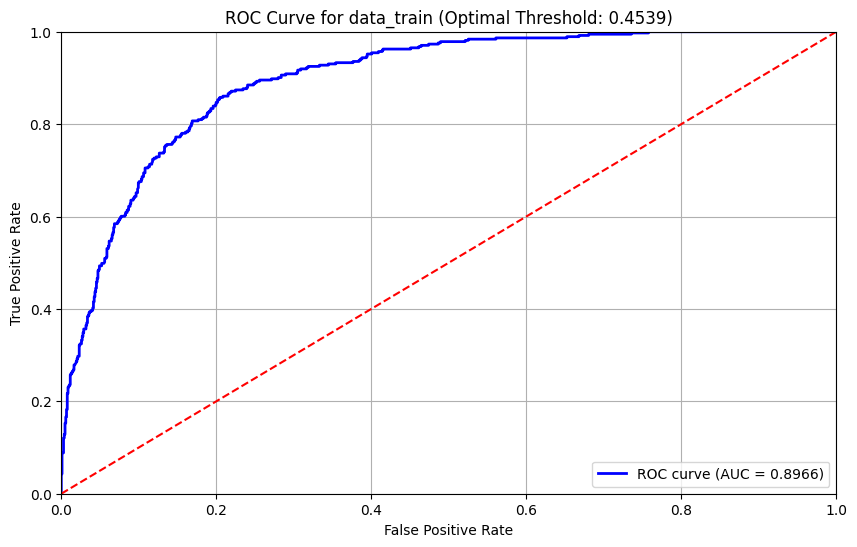

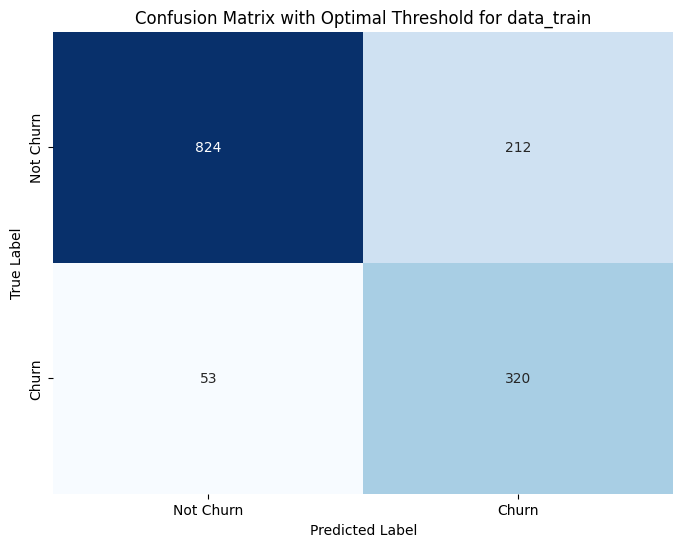

Optimal Threshold for data_train: 0.4539
ROC AUC for data_train: 0.8966

****************************************************************************************************



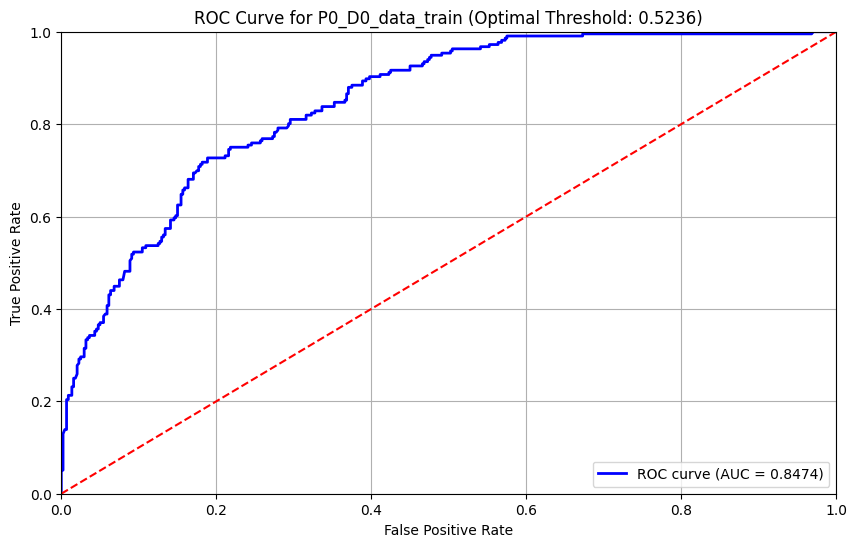

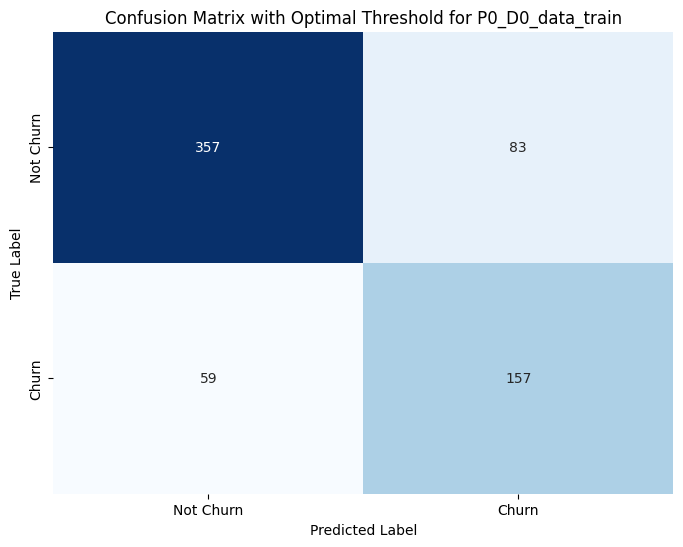

Optimal Threshold for P0_D0_data_train: 0.5236
ROC AUC for P0_D0_data_train: 0.8474

****************************************************************************************************



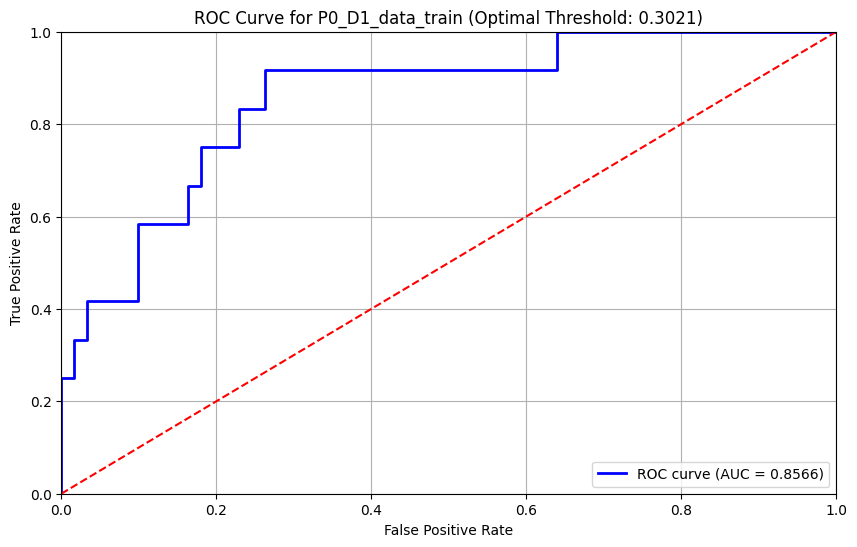

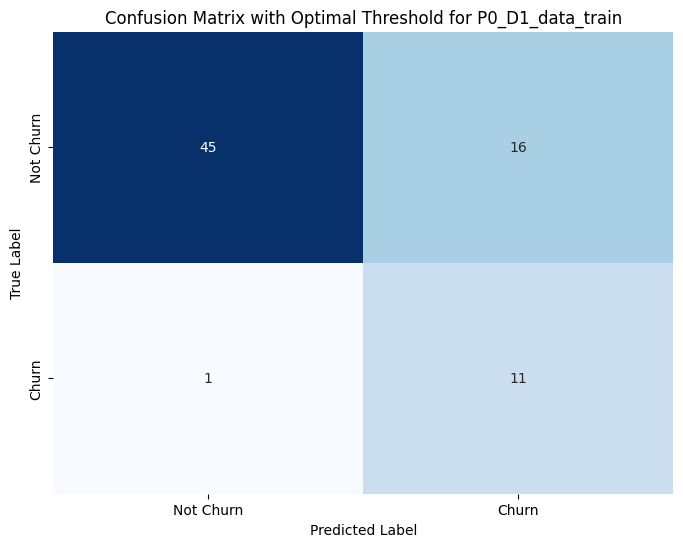

Optimal Threshold for P0_D1_data_train: 0.3021
ROC AUC for P0_D1_data_train: 0.8566

****************************************************************************************************



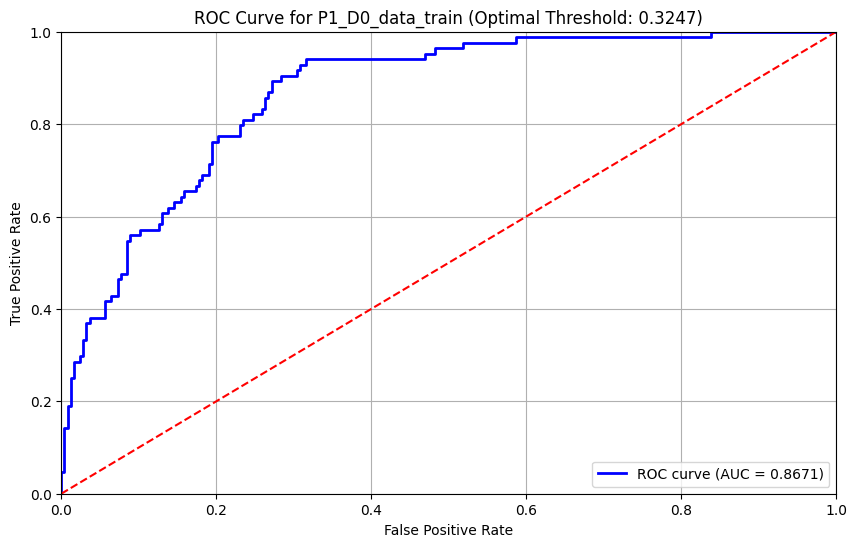

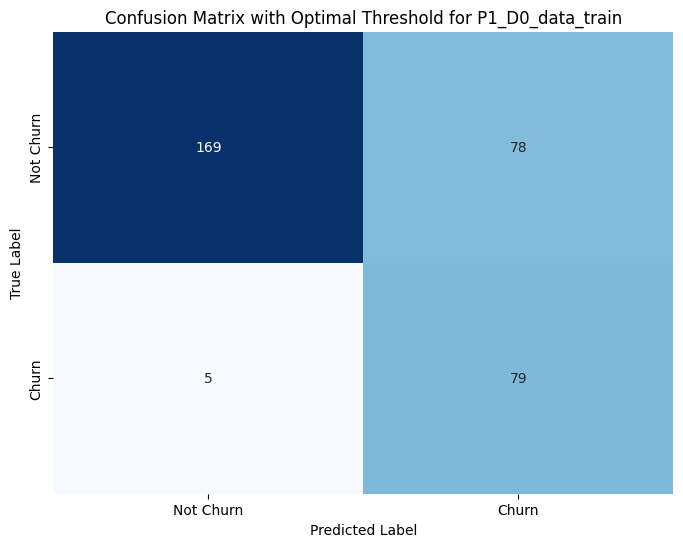

Optimal Threshold for P1_D0_data_train: 0.3247
ROC AUC for P1_D0_data_train: 0.8671

****************************************************************************************************



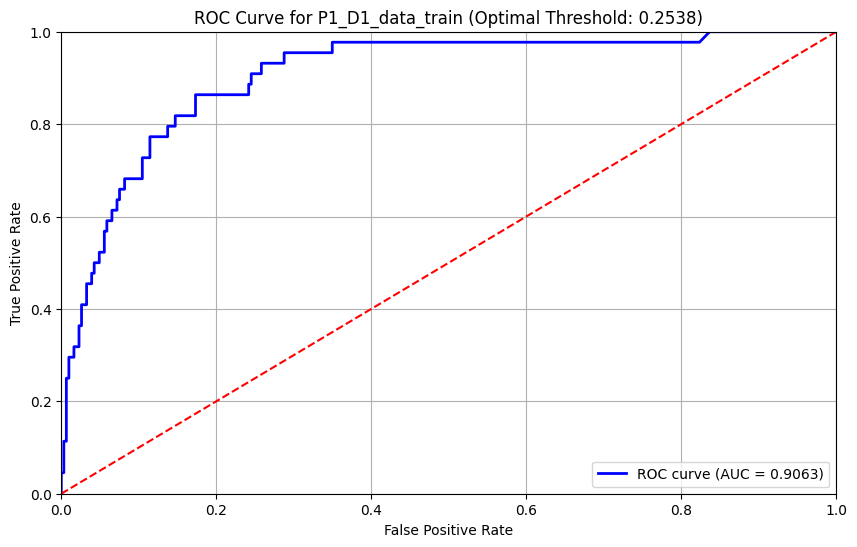

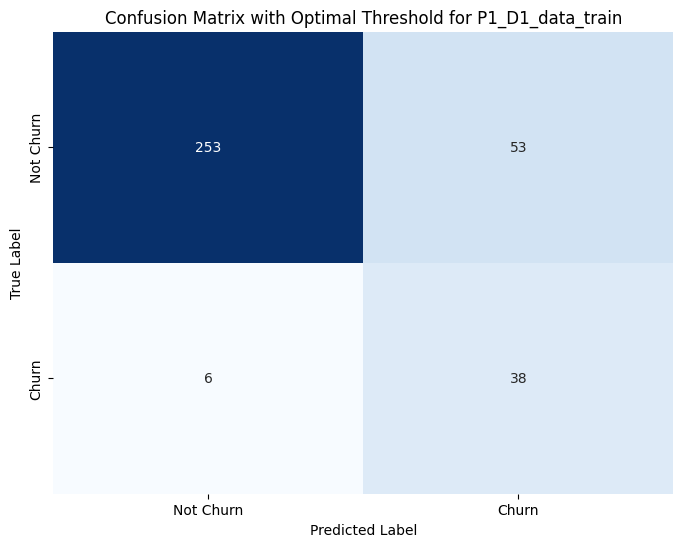

Optimal Threshold for P1_D1_data_train: 0.2538
ROC AUC for P1_D1_data_train: 0.9063

****************************************************************************************************



In [ ]:
''' check best model '''
def plot_roc_confusion_matrix(best_models, resampled_results):
    for key, model_info in best_models.items():
        test_key = key.replace("_train", "_test")
        data_test = resampled_results[test_key]
        X_test = data_test.drop(columns=["Churn"])
        y_test = data_test["Churn"]

        best_model = model_info['best_model']

        y_pred_proba = best_model.predict_proba(X_test)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        youden_index = tpr - fpr
        optimal_idx = np.argmax(youden_index)
        optimal_threshold = thresholds[optimal_idx]
        best_models[key]['optimal_threshold'] = optimal_threshold

        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {key} (Optimal Threshold: {optimal_threshold:.4f})')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

        y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

        conf_matrix = confusion_matrix(y_test, y_pred_optimal)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix with Optimal Threshold for {key}')
        plt.show()

        print(f"Optimal Threshold for {key}: {optimal_threshold:.4f}")
        print(f"ROC AUC for {key}: {roc_auc:.4f}")
        print()
        print("*"*100)
        print()


plot_roc_confusion_matrix(best_models, resampled_results)

In [ ]:
''' save best model '''

def train_and_save_models_with_test_data(best_models, resampled_results):
    for key, model_info in best_models.items():
        train_key = key
        test_key = key.replace("_train", "_test")

        train_data = resampled_results[train_key]
        test_data = resampled_results[test_key]

        combined_data = pd.concat([train_data, test_data], ignore_index=True)

        X_combined = combined_data.drop(columns=["Churn"])
        y_combined = combined_data["Churn"]

        best_model = model_info['best_model']
        best_model.fit(X_combined, y_combined)

        y_pred_proba = best_model.predict_proba(X_combined)[:, 1]

        optimal_threshold = model_info['optimal_threshold']
        y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

        print(f"Classification report for {test_key} (Train + Test combined):\n{classification_report(y_combined, y_pred_optimal)}")

        auc_score = roc_auc_score(y_combined, y_pred_proba)
        print(f"AUC Score for {key}: {auc_score:.4f}")

        model_filename = f"{key}_model.pkl"
        with open(model_filename, 'wb') as file:
            pickle.dump({
                'model': best_model,
                'optimal_threshold': optimal_threshold
            }, file)

        print(f"Combined model and optimal threshold saved as {model_filename}")

train_and_save_models_with_test_data(best_models, resampled_results)

Classification report for data_test (Train + Test combined):
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      5174
           1       0.80      0.93      0.86      4511

    accuracy                           0.85      9685
   macro avg       0.86      0.86      0.85      9685
weighted avg       0.86      0.85      0.85      9685

AUC Score for data_train: 0.9352
Combined model and optimal threshold saved as data_train_model.pkl
Classification report for P0_D0_data_test (Train + Test combined):
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2157
           1       0.76      0.79      0.77      1933

    accuracy                           0.78      4090
   macro avg       0.78      0.78      0.78      4090
weighted avg       0.78      0.78      0.78      4090

AUC Score for P0_D0_data_train: 0.8683
Combined model and optimal threshold saved as P0_D0_data_train_model.pkl
Classi